In [1]:
# #Mount your drive
# from google.colab import drive
# drive.mount('/content/drive')

# General directions
1.   Complete the code below to implement backpropagation for MLP and apply it to MNIST.
2. Using ChatGPT's assistance (or not), implement MLP with pytorch or tensorflow and apply it to MNIST. You will not be provided with the prompts this time. Compute the test accuracy. Use the same hyperparameters you used for part 1. (same number of hidden layer, learning rate, same activation function, etc.)

# Theoretical and Intuitive explanation for the MLP

If you already understand this, skip to the 'Code' section.

The main goal of this homework is to show how a MLP for a classification task works, and provide a general idea of how a neural network can 'learn'. Let's start form the very basic intuition, and then build up from there until the actual implementation of the MLP.

First, we will start from the task. We want to classify some images from the MNIST dataset. That is, we want a model that takes an image as an iput and reutrns the label.

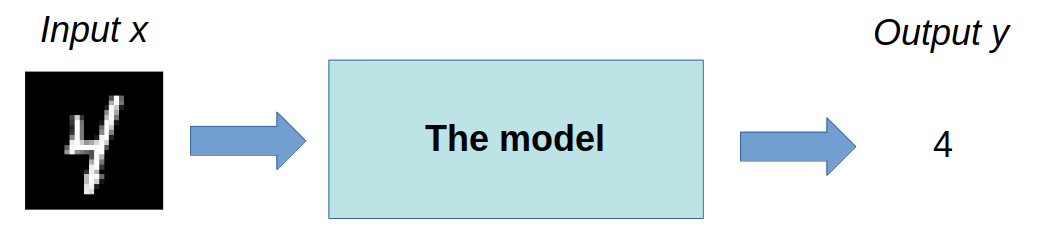

Basically speaking, this is just a (veeeeery complex) function y = f(x), where f is replaced with the model.

In our case, f(.)(the model) is the MLP network.

The input to our model would be the MNIST images. As we have seen many times, this images are described by their pixel values. For the MNIST case (grey-scale 28x28 pixel images), we only need one value for each pixel, ranging between 0-255. If it were a colored image, we would need 3 values per pixel (red-green-blue values.)

Our model should learn how each pixel value and location is related to the label of the images. The intuition is answering the question 'Why do this 784 pixel values represent a number 4?', for example.

First step, we want to 'flatten' our images. Instead of an array (matrix) of 28x28, we will input a 784 vector. That is, we will make a vector by puting each pixel of the image one next to the other. For the MLP, this step is a computational convenience. For an illustrative example, refer to the image below:

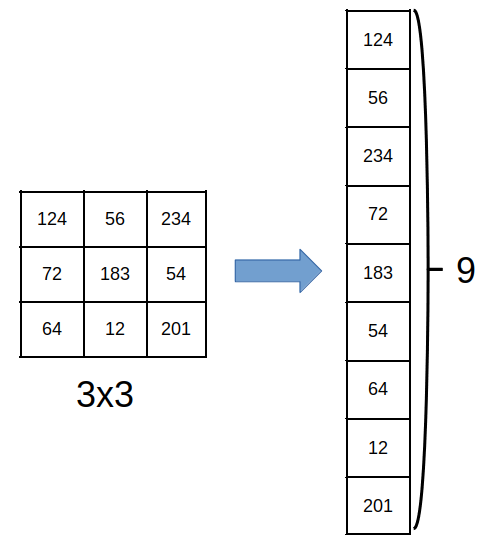

### Supervised learning and overall training

This classification task is using supervised learning. This means that during training we can adjust our estimation according to the correct labels.

The intuitive idea is as follows:
Given all the input images, our model will precdict their labels and store the 'reasoning' that led to this classification decision in the form of parameters (W, b). Then, we will compute a cost function. This cost function is a summation of all the errors in our predictions w.r.t the true labels. Intuitively, we want this cost function to be as small as possible, since it will mean that we made few wrong predictions. The process described in this paragraph is called ***forward propagation***.

But what if the classification that the model made is wrong for some labels? Given the cost function, we want to keep the 'reasoning' that led to a correct label, but change the 'resoning' that led to an incorrect label in such a way that next time we do forward propagation, when we see that image, we will predict the correct label. To do so, we have to 'go back' in our reasoning process starting from this cost function and change the parameters that led to a wrong prediction. We do this via computing the gradients of all the variables and parameters that led to this cost function. This process is called ***backward propagation***.

Finally, with the information of the gradients, we want to change the parameters a little in the direction that minimizes the cost function. There are several ways of updating the parameters, and this step is called **optimization**. Finally, after we change our parameters, we update the old ones by replacing them with these changed ones. It is like updating our 'reasoning'.

After all this, we forward propagate all the images one more time with the new parameters and obtain a new classification. We compare our estimation with the true labels and backward propagate. We update our parameters. And repeat.

To recapitulate, training an MLP classifier has three main parts:

1. **Forward propagation:** classify all the images in the training set using the model and check the the predicted labels with the true labels using the cost function.
2. **Backward propagation:** go back in our reasoning and compute the derivatives of our cost function w.r.t. the parameters and variables we computed.
3. **Update:** change the parameter values that gave us the wrong labels in the direction that minimizes the error. Update the parameter values for the next forward propagation.

Finally, when we trained our model to make the best possible predictions, we stop and save these parameters.

To test if our model can generalize, that is, to perform well given unseen data points, we apply forward propagation to a new dataset (called test dataset) and we check the accuracy of our label predictions in this set. Why don't we backpropagate in this case? Because we are done training, we don't want to update the parameters any more with this test set.

### MLP architecture

Now we will talk about the MPL (our model) architecture.
The MLP architecture is made of:

1.   **Input:** The input vector to our model (in this case, 784-dimensional vectors)
2.   **Hidden Layer(s):** a layer is a set of *k* neurons. Each neuron will capture information about each input pixel and store it in the parameters. We can have different layers with different number of neurons.
3. **Output Layer:** The last neuron that outputs the prediction (in this case, the labels)

In this case, Professor said that we need only one hidden layer. So, our architecture will be like this:

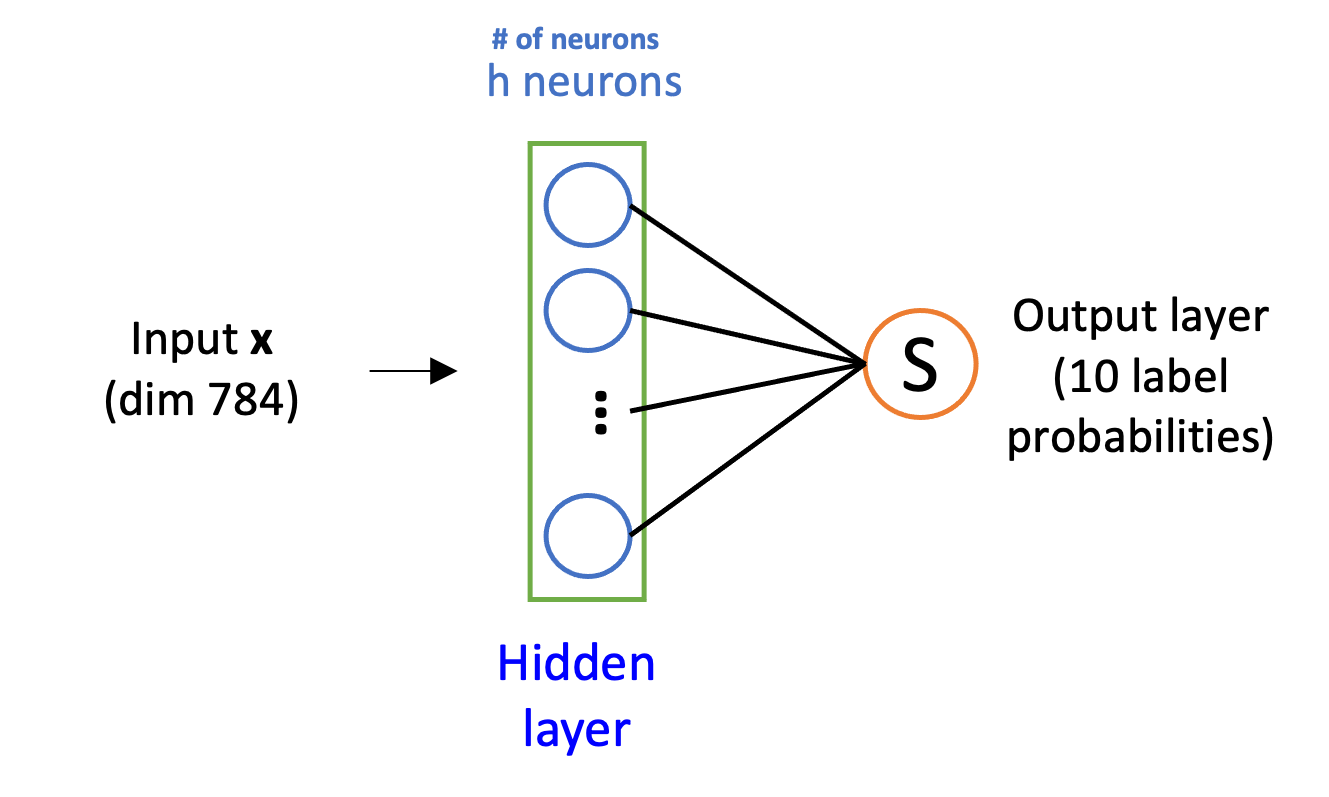

## Code

Follow and complete the following Collab so that the code runs correctly.

In [2]:
#### Import your libraries (remember, no built-in library)
import six.moves.cPickle as pickle
import gzip
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import random
from sklearn import metrics
import time
import urllib.request

Function to load the MNIST data:

In [3]:
# #Mount your drive
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
def load_data(dataset):
    ''' Loads the dataset

    :type dataset: string
    :param dataset: the path to the dataset (here MNIST)

    copied from http://deeplearning.net/ and revised by hchoi
    '''

    # Download the MNIST dataset if it is not present
    if not os.path.isfile(dataset):
        origin = (
            'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        )
        print('Downloading data from %s' % origin)
        urllib.request.urlretrieve(origin, dataset)

    print('Loading data...')

    # Load the dataset
    with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)
    # train_set, valid_set, test_set format: tuple(input, target)
    # input is a numpy.ndarray of 2 dimensions (a matrix)
    # where each row corresponds to an example. target is a
    # numpy.ndarray of 1 dimension (vector) that has the same length as
    # the number of rows in the input. It should give the target
    # to the example with the same index in the input.
    print('... data has been loaded!')
    return train_set, valid_set, test_set

In [5]:
  train_set, val_set, test_set = load_data('./mnist.pkl.gz')

  ## We will not use a validation set, but you can if you want to :)
  ## train_x and test_x contain the images for training and testing.
  train_x, train_y = train_set
  test_x, test_y = test_set
  print('The amount of images in your training set is: ', train_x.shape[0])
  print('The amount of images in your testing set is: ', test_x.shape[0])

Loading data...
... data has been loaded!
The amount of images in your training set is:  50000
The amount of images in your testing set is:  10000


### Pre-processing

First, we have to pre-process the dataset. The first one is to scale our dataset by substracting the mean. This is called normalization and it helps the model to have inputs that have a similar scale of values.


In [6]:
def norm(X):
    return X - np.mean(X, axis=0)

train_scaled = norm(train_x)
test_scaled = norm(test_x)

Now, we will define a function to convert our labels into one-hot-encoded vectors. This is also convenient in terms of computation during our training. Instead of having the labels as integers (0,1,2,3,4...,9) we will write them as 10 dimensional vectors of 0s and 1s as follows:

$0 = [1,0,0,0,0,0,0,0,0,0]$

$1 = [0,1,0,0,0,0,0,0,0,0]$

$2 = [0,0,1,0,0,0,0,0,0,0]$

.
.
.

$9 = [0,0,0,0,0,0,0,0,0,1]$

Lucky for us, the libraries like pytorch and similar do this automatically for us, so this step is not necessary when we use them. However, for this part of the homework we have to do this manually.

In [7]:
##We will use it later during training :)
def one_hot(y):
    one_hot = []
    oh = np.zeros(10, dtype=int)
    for i in y:
        oh[i] = 1
        one_hot.append(oh)
        oh = np.zeros(10, dtype=int)
    return np.asarray(one_hot)

#If you want, you can uncoment the ## and check if the function works:
Y = one_hot(train_y)
print(Y, Y.shape)
print('\n')
# Let's try with one example!
print('If the integer label is: ', train_y[2])
print('its one-hot-vector is: ', Y[2])

[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]] (50000, 10)


If the integer label is:  4
its one-hot-vector is:  [0 0 0 0 1 0 0 0 0 0]


### Model hyperparameters

Now we are going to define the model hyperparameters and other needed values. Remember, hyperparamenters mean **non**-trainable parameters, so they will not change throughout our training.

In [8]:
#Input dimension
x_dim = 28 * 28

#Number of neurons in our only hidden layer
h = 200

#Number of classes (10 classes for us)
C = 10

#Learning rate (how much do we want to change the parameters when we update, see details below):
lr = 0.05

#Epochs (How many times do we want to forward and backpropagate all our data?)
num_epochs=250

### Initialization

First, we need to define and initialize our parameters from the hidden layer and the ouput layer. We have 2 sets of parameter matrices ($W_{xh}$, $b_h$) for our only hidden layer and ($W_o$, $b_o$) for the output layer.

Can you think of the shape of these before we compute them? As a hint, refer to the structure of MLP:

In [9]:
def initp(x_dim, h, C):

    ##Initialize each array according to the corresponding dimension
    ## W@ are inistialized randomly, and b@ can be initialized as zero vectors (why can't W@ be zero?)

    W_xh = np.random.randn(x_dim, h) #complete the  ...
    b_h = np.zeros((1, h))
    Wo = np.random.randn(h, C)
    bo = np.zeros((1, C))

    ##Save the parameter values as a dictionary.
    ##This is our 'memory' where we store our parameters, and later we update them here.
    parameters = {"W_xh": W_xh,
                  "b_h": b_h,
                  "Wo": Wo,
                  "bo": bo}

    return parameters

parameters = initp(x_dim, h, C) ## <- check the dimensions are correct!

### Forward Propagation

Now let's see forward propagation in more detail. From the slides in the ppt (slide 10), each layer will compute $y_t$ and an activation $h_t$. Pay attention to the subscripts. ALSO, I changed the notation a little bit to make it a little more clear, but the equations are the same as in the ppt.

Each neuron in the hidden layer will take each pixel value from the input $X$ and multiply it by the weight matrix $W_{xh}$ and add the bias vector $b_h$. If we use matrix notation (so we don't have to use a for loop), this will be:

$Z_1=W_{xh} * X + b_h$

Then, we need to add the non-linearity through an activation function. See the pdf slides for some examples of activation functions. Again there is no rule to choose activation functions. For example, if we choose ReLU:

$A_1=ReLU(Z_1)$

This is it for the hidden layer. The input are the images $X$ as an array. The output is an array $A_1$.

Now, this $A_1$ is the array that contains information about the image. This is the input to our next layer (which in our case is our final layer, the output layer.) In this layer we use $A_1$ to compute a new vector

$Z_o=W_{ho} * A_1 + b_o$

And now, we transform this vector into probabilities using the softmax function:

$A_o=softmax(Z_o)$

That's it! This vector will give the probabilities of the input image being a certain label (so ten probabilities for each image in our array $X$... now you see why we needed the one-hot encoded vector?)

In [10]:
def relu(x) :
    return np.maximum(0, x)

In [11]:
##Let's do everything from scratch! even the softmax function :)
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def forward_prop(X, parameters):

    ##Let's load our current parameters
    W_xh = parameters["W_xh"]
    b_h = parameters["b_h"]
    Wo = parameters["Wo"]
    bo = parameters["bo"]

    ##This is basically the MLP:
    ##hidden layer:
    Z1 = np.dot(W_xh.T, X) + b_h.T
    A1 = relu(Z1) ##replace your_act with an activation of your liking like ReLU or tanh
    ##output layer:
    Zo = np.dot(Wo.T, A1) + bo.T #complete the  ...
    Ao = softmax(Zo) #complete the  ...

    ##we make a cache, that is a 'memory' so that later we can go back in our reasoning when we do back propagation
    cache = {"Z1": Z1,
             "A1": A1,
             "Zo": Zo,
             "Ao": Ao}

    ##the output is our probabilities.
    return Ao, cache

##Check!!
ao , cache = forward_prop(train_scaled.T, parameters)
print(ao.shape, cache)

(10, 50000) {'Z1': array([[ -3.29506995,  -5.47651095,   1.02616209, ...,   6.11637488,
         10.56861905,  -7.58424597],
       [ -1.05314582,  -9.20810569,   8.44109469, ...,   3.77353192,
         -7.9486425 ,  -7.04687225],
       [  1.17836919,  -1.52176333,   1.74763385, ...,  -6.65243456,
          6.81808456,   9.83119046],
       ...,
       [ -5.3203699 ,  -3.03962142,  -1.983775  , ...,   9.95161117,
         11.63020462,  -9.00793332],
       [ -4.05796712,   7.78183019, -18.98310247, ...,  -1.73012988,
          2.07184008, -10.57538007],
       [-11.34948127,   3.18137195,   1.28377325, ...,   1.92704102,
         -3.77508914,  -5.3238889 ]]), 'A1': array([[ 0.        ,  0.        ,  1.02616209, ...,  6.11637488,
        10.56861905,  0.        ],
       [ 0.        ,  0.        ,  8.44109469, ...,  3.77353192,
         0.        ,  0.        ],
       [ 1.17836919,  0.        ,  1.74763385, ...,  0.        ,
         6.81808456,  9.83119046],
       ...,
       [ 0.  

### The objective function (NLL)

First we need to define our cost function, the one that will give us the overall error we made in our predictions. We are going to use the negative log likelihood (NLL). Refer to slides 19 and 20 as a guide (I will change the notation slightly because I will use matrices.)

Let $Y$ be the true labels of our dataset and $A_o$ our estimation from the output layer in the MLP. For our $n$ samples we define the NLL as:

$\mathcal{L} = -\frac{1}{n}\sum_i^n Y_i * \ln(A_{o(i)})$

In [12]:
def nll_cost(Ao, Y, parameters):

    epsilon = 1e-15  # Small constant to prevent taking the logarithm of zero

    n = Y.shape[0]

    Ao = np.clip(Ao, epsilon, 1 - epsilon)

    logprobs = np.multiply(np.log(Ao), Y.T)
    cost =  (-1./n)*np.sum(logprobs)
    cost = np.squeeze(cost)

    return cost

nll_cost(ao, one_hot(train_y), parameters) # <- check!

29.75579257095598

### Backward propagation

Refer to the slides from 21 onwards (gradients for multiclass). Again, the notation changed a little, but we are doing what the ppt says.

Now we are going to revise our model from the output back to the input using the gradient of our loss (use the derivative chain rule!).

We start with the cost function (we use matrix notation, so we need the term $\frac{1}{n}$, for our $n$ samples):

$\mathcal{L} = -\frac{1}{n}\sum_i^n Y_i * \ln(A_{o(i)})$

and we compute the derivative $dZ_o = \frac{d\mathcal{L}}{dZ_o}$:

$dZ_o = \frac{\partial \mathcal{L}}{\partial A_o} \frac{\partial \mathcal{A_o}}{\partial Z_o} = A_o - Y$

We do the same for $dW_* = \frac{d\mathcal{L}}{dW_*}$, and $db_* = \frac{d\mathcal{L}}{db_*}$

Compute these derivatives yourself using the chain rule (use the slides 21 and 22 as reference)

In [13]:
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

In [14]:
def back_prop(parameters, cache, X, Y):

    ##Amount of examples
    n = X.shape[0]

    ##Load current parameter weights
    W_xh = parameters["W_xh"]
    Wo = parameters["Wo"]

    ##Load the activation information of each layer
    A1 = cache["A1"]
    Ao = cache["Ao"]

    ##Let's compute the derivatives! Note we are going backwards, from the output layer to the hidden layer
    dZo= Ao - Y.T
    #dim of dWo should be (10, 200)
    dWo = (1./n)*np.dot(dZo, A1.T) #complete the  ...
    #dim of dbo should be (10, 1)
    dbo = (1./n)*np.sum(dZo, axis=1, keepdims=True) #complete the  ...
    #dim of dZ1 should be (200, 50000)
    dZ1 = np.dot(Wo, dZo) * relu_derivative(A1) #complete the information wrt the activation that you chose
    #dim of dW_xh should be (200, 784)
    dW_xh = (1./n)*np.dot(dZ1, X) #complete the  ...
    #dim of db_h should be (200, 1)
    db_h = (1./n)*np.sum(dZ1, axis=1, keepdims=True) #complete the  ...

    # print("dZo",dZo.shape)
    # print("dWo",dWo.shape)
    # print("dbo",dbo.shape)
    # print("dZ1",dZ1.shape)
    # print("dW_xh",dW_xh.shape)
    # print("db_h",db_h.shape)


    ##Save the gradients in a dictionary to update the parameters
    grads = {"dW_xh": dW_xh,
             "db_h": db_h,
             "dWo": dWo,
             "dbo": dbo}

    return grads

#check!
grads = back_prop(parameters, cache, train_scaled, one_hot(train_y))

### Update

Now we have saved all our gradient information from the backward pass. It is time to update our parameters. This means that we will chage their values in the direction that minimizes the cost.

We have different dtrategies to update our parameters, but we will use the simple gradient descent algorithm. The parameter updates will be given by:

$W := W - \alpha . dW$

$b := b - \alpha . db$

The intuition is that we update each value in our parameters 'a little' (we control how much through the learning rate lr = $\alpha$) in the direction that minimizes the gradient.

In [15]:
def update(parameters, grads, lr):

    #Load your current parameters from the forward prop step
    W_xh = parameters["W_xh"]
    b_h = parameters["b_h"]
    Wo = parameters["Wo"]
    bo = parameters["bo"]

    #Load the derivatives of your parameters from the backward step
    dW_xh = grads["dW_xh"]
    db_h = grads["db_h"]
    dWo = grads["dWo"]
    dbo = grads["dbo"]

    #Update your parameters using the gradient descent algorithm
    W_xh = W_xh - lr * dW_xh.T
    b_h = b_h - lr * db_h.T
    Wo = Wo - lr * dWo.T
    bo = bo - lr * dbo.T

    #Store your new parameters
    parameters = {"W_xh": W_xh,
                  "b_h": b_h,
                  "Wo": Wo,
                  "bo": bo}

    return parameters
update(parameters, grads, lr)

{'W_xh': array([[ 0.49150056,  0.46550439,  0.43252281, ...,  2.0297887 ,
         -0.54340539,  1.62900278],
        [-0.5967751 ,  0.20455869, -0.03823848, ...,  0.684279  ,
          0.48418051,  2.16168417],
        [ 0.38659103, -1.43369823, -2.05872011, ...,  0.04415452,
          0.64265182, -0.22748714],
        ...,
        [-0.85098781,  1.91036087,  0.25682884, ..., -1.88476822,
         -1.82524303,  1.11657335],
        [-0.15520462,  1.76564492,  1.29274783, ..., -0.71284455,
         -3.35126033,  1.27000755],
        [-1.06404098, -0.45778963,  1.20874745, ..., -1.02166876,
         -0.27349001,  0.79484742]]),
 'b_h': array([[-1.07158255e-02,  5.99675775e-03, -1.35808986e-02,
          2.84507000e-03, -2.68641939e-03, -6.45648972e-04,
         -6.52059926e-03,  8.90668186e-04, -1.54426516e-03,
          2.60869244e-03,  5.76313059e-03,  4.61405339e-03,
         -3.32642624e-03,  5.87106039e-03, -7.63525976e-03,
          3.39293484e-03, -5.29430819e-03, -1.90339447e-02

### Almost done!

Before putting everything together for training, let's define one more function. This will compute the accuracy of our predictions during training, and this way we can control how the model is working during training. It is not mandatory, but it is useful and later you can use it for testing.

In [16]:
def predict(prediction, label):
    #get the label with the maximum probability in our estimation
    predictions = np.argmax(prediction, axis=0)
    # labels = np.argmax(label, axis=1)
    # print(label)

    #check our estimation wrt the true label
    new = np.array([label[i] == predictions[i] for i,_ in enumerate(label)], dtype=np.bool)
    #compute the accuracy
    acc = np.count_nonzero(new*1)/label.shape[0]

    return acc * 100

### All together: the MLP training


Let's put every part we defined together.

In [17]:
def MLP_model_train(X, train_y, H, O, D, lr, num_epochs, print_cost):

    ##initialize the parameters
    parameters = initp(D, H, O)

    ##Load your initialized values
    W_xh = parameters["W_xh"]
    b_h = parameters["b_h"]
    Wo = parameters["Wo"]
    bo = parameters["bo"]

    cost_per_epoch = []
    #Train!
    for i in range(0, num_epochs):
        #forward prop
        Ao, cache = forward_prop(X, parameters) #complete the  ...

        #compute the cost and save it
        cost = nll_cost(Ao, one_hot(train_y), parameters) #complete the  ...
        cost_per_epoch.append(cost)

        #compute the ccuracy just for reference
        acc = predict(Ao, train_y) #complete the  ...

        #backpropagate!
        grads = back_prop(parameters,cache, X.T, one_hot(train_y)) #complete the  ...

        #update!
        parameters = update(parameters, grads, lr) #complete the  ...

        ##print the results every 10 epochs
        if print_cost and i % 10 == 0:
            print ("Cost after iteration %i: %f with accuracy of %f" %(i, cost, acc))

    print('Training ended.')
    return parameters, cost_per_epoch

trained_paramter, cost = MLP_model_train(train_scaled.T, train_y, h, C, x_dim, lr, num_epochs, print_cost=True)

<ipython-input-16-7a32a2bd35e6>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  new = np.array([label[i] == predictions[i] for i,_ in enumerate(label)], dtype=np.bool)


Cost after iteration 0: 29.116323 with accuracy of 10.304000
Cost after iteration 10: 17.963334 with accuracy of 37.586000
Cost after iteration 20: 13.097664 with accuracy of 51.576000
Cost after iteration 30: 10.656572 with accuracy of 59.294000
Cost after iteration 40: 9.183819 with accuracy of 64.236000
Cost after iteration 50: 8.168091 with accuracy of 67.490000
Cost after iteration 60: 7.410519 with accuracy of 70.132000
Cost after iteration 70: 6.831540 with accuracy of 72.052000
Cost after iteration 80: 6.370183 with accuracy of 73.622000
Cost after iteration 90: 5.992269 with accuracy of 74.994000
Cost after iteration 100: 5.675003 with accuracy of 76.158000
Cost after iteration 110: 5.408422 with accuracy of 77.198000
Cost after iteration 120: 5.181172 with accuracy of 78.032000
Cost after iteration 130: 4.982529 with accuracy of 78.740000
Cost after iteration 140: 4.805205 with accuracy of 79.390000
Cost after iteration 150: 4.646116 with accuracy of 79.988000
Cost after iter

**How do we know if the training is running fine?**


1.   The cost should decrease in each epoch
2.   The accuracy should increase in each epoch

**Does it take long to train and get a good accuracy?**
Yes, it does, so patience :) (but if it takes more than 2 hours it is suspicious)

**When do I stop training?** When the cost does not change anymore and starts fluctuating around a certain value (it means it converged)

### Testing

Define the function to test your trained model. We will give you a very general outline. Report the final test accuracy.

In [18]:
#This one is a pseudo-code, make sure it works :)
def test(parameters, test_im, test_labels):

  ##Forward prop your new images using your trained parameters
  a_test, cache = forward_prop(test_im, parameters)
  ##Check the accuracy
  acc = predict(a_test, test_labels)
  ##compute the cost function of the testing
  cost = nll_cost(a_test, one_hot(test_labels), parameters)
  return "Cost for test dataset: %f with accuracy of %f" %(cost, acc)

In [19]:
test(trained_paramter, test_scaled.T, test_y)

<ipython-input-16-7a32a2bd35e6>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  new = np.array([label[i] == predictions[i] for i,_ in enumerate(label)], dtype=np.bool)


'Cost for test dataset: 3.722670 with accuracy of 83.830000'

# Pytorch or Tensorflow implementation

Insert the pytorch (or TensorFlow) implementation below.

In [20]:
# Code here

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [21]:
#Input dimension
x_dim = 28 * 28

#Number of neurons in our only hidden layer
h = 200

#Number of classes (10 classes for us)
C = 10

#Learning rate (how much do we want to change the parameters when we update, see details below):
lr = 0.05

#Epochs (How many times do we want to forward and backpropagate all our data?)
num_epochs=250

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.hidden_activation = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.output_activation = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.hidden_activation(x)
        x = self.output_layer(x)
        x = self.output_activation(x)
        return x

def MLP_model_train(X, train_y, H, O, D, lr, num_epochs, print_cost):
    # Convert X and train_y to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    train_y_tensor = torch.tensor(train_y, dtype=torch.long)


    train_y_one_hot = torch.nn.functional.one_hot(train_y_tensor, num_classes=O)

    # Build the MLP model
    model = MLPModel(input_size=D, hidden_size=H, output_size=O)


    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    cost_per_epoch = []

    # Train the model
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_tensor)

        # Compute the loss
        loss = criterion(torch.log(outputs), train_y_tensor)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost = loss.item()
        acc = torch.sum(torch.argmax(outputs, dim=1) == train_y_tensor).item() / len(train_y_tensor)
        cost_per_epoch.append(cost)


        if print_cost and epoch % 10 == 0:
            print(f"Cost after iteration {epoch}: {cost} with accuracy of {acc}")

    print('Training ended.')
    return model, cost_per_epoch


In [23]:
trained_model, _ = MLP_model_train(train_scaled, train_y, h, C, x_dim, lr, num_epochs, print_cost=True)

Cost after iteration 0: 2.296703338623047 with accuracy of 0.1445
Cost after iteration 10: 2.2254602909088135 with accuracy of 0.32438
Cost after iteration 20: 2.1508891582489014 with accuracy of 0.463
Cost after iteration 30: 2.068268060684204 with accuracy of 0.54924
Cost after iteration 40: 1.9747178554534912 with accuracy of 0.59622
Cost after iteration 50: 1.8703107833862305 with accuracy of 0.6235
Cost after iteration 60: 1.758245587348938 with accuracy of 0.64524
Cost after iteration 70: 1.6432551145553589 with accuracy of 0.66184
Cost after iteration 80: 1.5292432308197021 with accuracy of 0.67874
Cost after iteration 90: 1.4189378023147583 with accuracy of 0.69634
Cost after iteration 100: 1.314700961112976 with accuracy of 0.71418
Cost after iteration 110: 1.2184711694717407 with accuracy of 0.73118
Cost after iteration 120: 1.1312980651855469 with accuracy of 0.74796
Cost after iteration 130: 1.0533384084701538 with accuracy of 0.76276
Cost after iteration 140: 0.98413461446

In [24]:
def MLP_model_test(X, model, true_labels):
    # Convert X to a PyTorch tensor
    X_tensor = torch.tensor(X, dtype=torch.float32)

    outputs = model(X_tensor)

    predictions = torch.argmax(outputs, dim=1).numpy()
    true_labels_tensor = torch.tensor(true_labels, dtype=torch.long)

    acc = torch.sum(torch.argmax(outputs, dim=1) == true_labels_tensor).item() / len(true_labels_tensor)

    print(acc)

    return predictions

test_predictions = MLP_model_test(test_scaled, trained_model, test_y)

0.8644


# Report

1.   Compare the test accuracy of the two implementations (from scratch vs pytorch's). Which one was better?

Learning Rate: 0.05 - 83.740000 accuracy in manual / 86.44 accuracy using PyTorch.

Learning Rate: 0.01 - 66.740000 in manual / 66.76 accuracy using PyTorch.

On 5 times average

It is hard to say with small trials, but implementation with PyTorch showed higher accuracy, but there was no huge difference. Also, the result will be promising with more epochs with appropriate learning rates.

2.   Conclude with some thoughts and things you learned from this homework. <br>

While I was doing homework, using appropriate hyperparameters was my main concern. A higher learning rate will make the overshooting and miss the convergence. The original code’s learning rate was 5, so PyTorch Implementation and manual implementation kept skipping over the minimum of the loss function, falling on the incorrect minimum. Also, with the various experiments, I could learn how rates and epochs affect the results.
ANN is used in many areas for now. Backpropagation makes this thing possible. However, it seems like it is more like a black box.
